# Network definitions

In [2]:
# Definitions
from tensorflow.keras import layers as L 
import tensorflow as tf
from functools import reduce

import numpy as np

class ResidualConv(tf.keras.Model):
    def __init__(self, filters, kernel_size, use_bn=True, activation=tf.nn.elu, **kwargs):
        super().__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.c1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME', **kwargs)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.c2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME', **kwargs)
        self.activation = activation
    @tf.function
    def call(self, x):
        y = self.activation(self.c1(self.bn1(x)))
        y = self.activation(self.c2(self.bn2(y)))
        #print(x.shape)
        return y + x

def round_even(x):
    if x % 2 == 0:
        return x + 1
    else:
        return x + 2
    
class ConvRegressor(tf.keras.Model):
    def __init__(
        self, filters, kernel_size, 
        conv_type=tf.keras.layers.Conv2D, activation=tf.nn.elu, 
        **kwargs
    ):
        super().__init__()
        self.filters = filters
        self.conv_type = conv_type
        self.convs = []
        for n_filter in filters:
            self.convs.append(
                conv_type(n_filter, round_even(kernel_size), strides=2, padding='SAME', activation=activation, **kwargs)
            )
            self.convs.append(conv_type(n_filter, kernel_size, padding='SAME', activation=activation, **kwargs))
        self.convs.append(tf.keras.layers.Conv2D(n_filter, kernel_size, padding='SAME'))

    @tf.function
    def call(self, x):
        y = x
        for conv in self.convs:
            y = conv(y)
        return y

class ResidualConvRegressor(tf.keras.Model):
    def __init__(
        self, filters, out_ch, kernel_size, n_freq_residual, 
        conv_type=tf.keras.layers.Conv2D, activation=tf.nn.elu, 
        **kwargs
    ):
        super().__init__()
        self.filters = filters
        self.n_freq_residual = n_freq_residual
        self.conv_type = conv_type
        self.convs = []
        for n_filter in filters:
            self.convs.append(
                conv_type(
                    n_filter, round_even(kernel_size), strides=2, 
                    activation=activation, padding='SAME', **kwargs)
            )
            for i in range(n_freq_residual):
                self.convs.append(
                    ResidualConv(n_filter, kernel_size, activation=activation, **kwargs)
                )
        self.convs.append(tf.keras.layers.Conv2D(out_ch, kernel_size, padding='SAME'))
    @tf.function
    def call(self, x):
        y = x
        for conv in self.convs:
            y = conv(y)
        return y
    
class ConvVAE(tf.keras.Model):
    def __init__(
        self, dim_list, latent_dim, out_ch=1, kernel_size=3, 
        deconv_start_dim=16, crop_bb=None, **kwargs
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.crop_bb = crop_bb
        self.out_ch = out_ch
        self.inference_net = self.create_regressor(
            dim_list, kernel_size, conv_type=tf.keras.layers.Conv2D,
            **kwargs)
        self.dense_inference = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim * 2),
        ])
        self.deconv_start_dim = deconv_start_dim
        self.dense_z = tf.keras.layers.Dense(self.deconv_start_dim)
        self.generative_net = self.create_regressor(
            dim_list[::-1], kernel_size, conv_type=tf.keras.layers.Conv2DTranspose,
            **kwargs)
        self.final_conv = tf.keras.layers.Conv2D(out_ch, kernel_size, padding='SAME')

    def create_regressor(self, dim_list, kernel_size, **kwargs):
        return ConvRegressor(dim_list, kernel_size=kernel_size, **kwargs)

    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        d = self.decode(z)
        return self.crop(d)
    
    @tf.function
    def crop(self, x):
        if self.crop_bb is None:
            return x
        else:
            return tf.image.crop_to_bounding_box(x, *self.crop_bb)
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        self.orig_latent = self.inference_net(x)
        self.latent = self.dense_inference(self.orig_latent)
        mean, logvar = tf.split(self.latent, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        z = self.dense_z(z)
        s = int(np.sqrt(self.deconv_start_dim))
        z = tf.reshape(z, (tf.shape(z)[0], s, s, 1))
        logits = self.final_conv(self.generative_net(z))
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits
    
class ResidualConvVAE(ConvVAE):
    def __init__(
        self, dim_list, latent_dim, 
        out_ch=1, n_freq_residual=4,
        kernel_size=3, crop_bb=None, **kwargs
    ):
        self.n_freq_residual = n_freq_residual
        super().__init__(dim_list, latent_dim, out_ch=out_ch, kernel_size=kernel_size, crop_bb=crop_bb, **kwargs)

    def create_regressor(self, dim_list, kernel_size, **kwargs):
        return ResidualConvRegressor(
            dim_list, dim_list[-1], kernel_size=kernel_size,
            n_freq_residual=self.n_freq_residual, **kwargs)

class ResiaudlConvDiscriminator(tf.keras.Model):
    def __init__(
        self, filters, out_dim, kernel_size, n_freq_residual, 
    ):
        super().__init__()
        self.convs = ResidualConvRegressor(
            filters[:-1], filters[-1], kernel_size, n_freq_residual)
        self.dense = tf.keras.layers.Dense(out_dim)

    @tf.function
    def call(self, x):
        return self.dense(self.convs(x))


class ResidualDense(tf.keras.Model):
    def __init__(self, units, use_bn=True, activation=tf.nn.elu, **kwargs):
        super().__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.d1 = tf.keras.layers.Dense(units, **kwargs)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.d2 = tf.keras.layers.Dense(units, **kwargs)
        self.activation = activation
    @tf.function
    def call(self, x):
        y = self.activation(self.d1(self.bn1(x)))
        y = self.activation(self.d2(self.bn2(y)))
        return y + x


class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, n_layers=40, **kwargs):
        super().__init__()
        self.d0 = tf.keras.layers.Dense(output_dim, activation=tf.nn.elu, **kwargs)
        self.dense_layers = [
            ResidualDense(output_dim, **kwargs) for i in range(n_layers)
        ]
        self. d1 = tf.keras.layers.Dense(output_dim, activation=None)
    @tf.function
    def call(self, x):
        y0 = self.d0(x)
        for layer in self.dense_layers:
            y0 = layer(y0)
        y = self.d1(y0)
        return y
    
    
net = ResidualConvVAE([8, 16, 32, 64], 12, n_freq_residual=4, kernel_size=3, out_ch=1, crop_bb=(16, 16, 32, 32))
output = net(tf.random.uniform((4, 64, 64, 1)))
net.summary()
print(output.shape)


Model: "residual_conv_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_conv_regressor (Res multiple                  500928    
_________________________________________________________________
sequential (Sequential)      multiple                  24600     
_________________________________________________________________
dense_1 (Dense)              multiple                  208       
_________________________________________________________________
residual_conv_regressor_1 (R multiple                  465984    
_________________________________________________________________
conv2d_70 (Conv2D)           multiple                  73        
Total params: 991,793
Trainable params: 987,953
Non-trainable params: 3,840
_________________________________________________________________
(4, 32, 32, 1)


# Load dataset

In [3]:
import imageio
from pathlib import Path
from tqdm.notebook import tqdm, trange
task = 'cable'
dataset_root_dir = Path('mvtec_anomaly_detection')

task_dataset_dir = dataset_root_dir / task
train_images = [imageio.imread(str(file))[None] for file in tqdm(list((task_dataset_dir / 'train' / 'good').glob('*.png')))]
train_labels = ['good' for _ in train_images]

test_images = []
test_labels = []
for mode_dir in tqdm(list((task_dataset_dir / 'test').glob('*'))):
    if not mode_dir.is_dir():
        continue
    images = [imageio.imread(file)[None] for file in mode_dir.glob('*.png')]
    test_images.extend(images)
    test_labels.extend([mode_dir.name for _ in images])

train_images = np.concatenate(train_images, axis=0).astype(np.float32) / 255
test_images = np.concatenate(test_images, axis=0).astype(np.float32) / 255

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
BATCH_SIZE = 4

label_dict = {
    'good': 0
}
train_labels = np.array([0 for _ in train_labels]).astype(np.int32)
label_dict.update({
    label:i+1 for i, label in enumerate(np.unique(test_labels))
    if label not in label_dict
})
test_labels = np.array([label_dict[t] for t in test_labels]).astype(np.int32)

train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)
train_dataset = train_dataset.shuffle(BATCH_SIZE*10, reshuffle_each_iteration=True).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(BATCH_SIZE*5).batch(BATCH_SIZE)

# Training

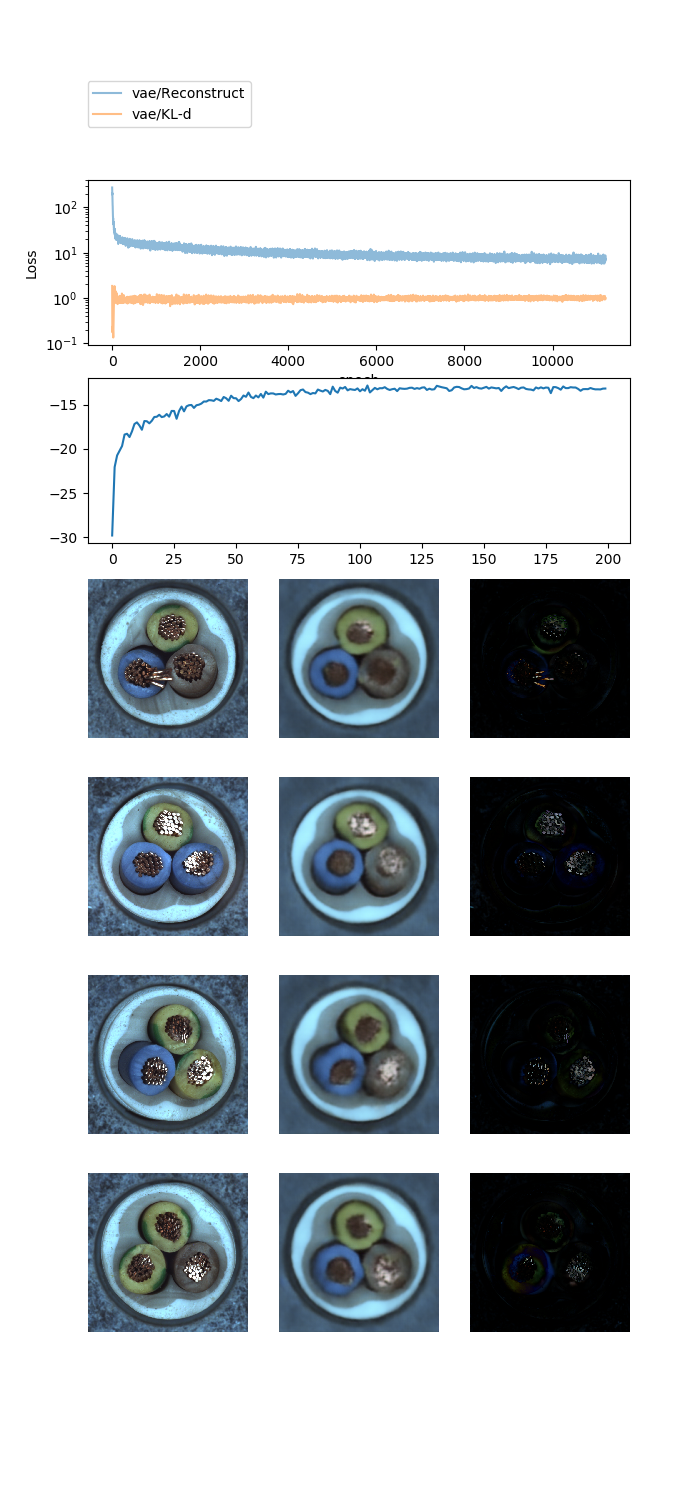

In [6]:
# from IPython import display
import IPython 
from collections import defaultdict 
from itertools import product
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import time
import seaborn as sns
from io import BytesIO
import imageio
from IPython.display import Image, display_png, clear_output

%matplotlib widget
#%matplotlib notebook


epochs = 200
latent_dim = 64
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
model = ResidualConvVAE(
    [4, 8, 12, 16, 20, 24, 32], latent_dim, 
    deconv_start_dim=64, out_ch=3, 
    kernel_size=3, n_freq_residual=2)
#model = ResidualConvVAE([3, 4, 8, 16], latent_dim, kernel_size=3, n_freq_residual=4) # For original size
optimizer = tf.keras.optimizers.Adam(5e-4)
# img_disc =ResiaudlConvDiscriminator(
#         filters=[4, 8, 16], out_dim=2, kernel_size=3, n_freq_residual=4)
# img_disc_optimizer = tf.keras.optimizers.Adam(8e-5)

state_training = 0

def gaussian_kl_divergence(mean, ln_var, raxis=1):
    var = tf.exp(ln_var)
    mean_square = mean * mean
    return tf.reduce_sum((mean_square + var - ln_var - 1) * 0.5, axis=raxis)

#@tf.function
def compute_loss(model, x):
    # Compute VAE loss
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    reconst_x = model.decode(z)

    absolute_error = (reconst_x - x) ** 2 
    loss_reconst = tf.reduce_sum(absolute_error, axis=1)
    loss_kld = gaussian_kl_divergence(mean, logvar)
    
    return {
        'loss': {
            'Reconstruct': tf.reduce_mean(loss_reconst),
            'KL-d': tf.reduce_mean(loss_kld) * 1e-2,
        },
        'raw': {
            'AE': absolute_error, 
            'Original': x,
            'Reconstruct': reconst_x,
        }
    }

#@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        losses = compute_loss(model, x)
        loss = sum(losses['loss'].values())
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return losses

#fig, axes = plt.subplots(3, 1, figsize=(5, 8))
fig = plt.figure(figsize=(7, 15))
grid_shape = (6, 3)
loss_ax = plt.subplot2grid(shape=grid_shape, loc=(0, 0), colspan=grid_shape[1], fig=fig)
elbo_ax = plt.subplot2grid(shape=grid_shape, loc=(1, 0), colspan=grid_shape[1], fig=fig)
data_ax = np.zeros((4,3), dtype=np.object)
for i in range(4):
    for j in range(3):
        data_ax[i, j] = plt.subplot2grid(shape=grid_shape, loc=(2 + i, j), fig=fig)

        
plt.ion()
fig.show()
fig.canvas.draw()

loss_history = defaultdict(list)
elbo_history = []
with tf.device('/GPU:0'):
    for epoch in trange(1, epochs + 1):
        start_time = time.time()
        for train_x in tqdm(train_dataset):
            data = compute_apply_gradients(model, train_x, optimizer)
            for name, loss in data['loss'].items():
                loss_history[f'vae/{name}'].append(loss.numpy())
#             for name, loss in data['loss_img_disc'].items():
#                 loss_history[f'ImageDiscriminator/{name}'].append(loss.numpy())
            
        end_time = time.time()

        if epoch % 1 == 0:
            loss = tf.keras.metrics.Mean()
            raw = None
            for test_x in tqdm(test_dataset):
                losses = compute_loss(model, test_x)
                if raw is None:
                    raw = losses['raw']
                loss(sum(losses['loss'].values()))
            elbo = -loss.result()
            elbo_history.append(elbo)
            
            loss_ax.clear()
            for name, loss in loss_history.items():
                loss_ax.plot(loss, label=name, alpha=0.5)
            loss_ax.set_xlabel('epoch')
            loss_ax.set_ylabel('Loss')
            loss_ax.set_yscale('log')
            loss_ax.legend(bbox_to_anchor=(0, 1.6), loc='upper left', borderaxespad=0)

            elbo_ax.clear()
            elbo_ax.plot(elbo_history)

            original = np.squeeze(raw['Original'].numpy())
            reconstruct = np.squeeze(raw['Reconstruct'].numpy())
            absolute_error = np.squeeze(raw['AE'].numpy())
            if np.any(np.isnan(absolute_error)):
                tqdm.write('The output is nan.')
            for i in range(4):
                ax = data_ax[i, 0]
                ax.clear()
                ax.imshow(original[i], vmin=0.0, vmax=1.0)
                ax.axis('off')
                
                ax = data_ax[i, 1]
                ax.clear()
                ax.imshow(reconstruct[i], vmin=0.0, vmax=1.0)
                ax.axis('off')
                
                ax = data_ax[i, 2]
                ax.clear()
                ax.imshow(absolute_error[i], vmin=0.0, vmax=1.0)
                ax.axis('off')
            
            io = BytesIO()
            fig.savefig(io, format='png')

            clear_output(wait=True)
            display_png(Image(io.getvalue()))


In [10]:
from pathlib import Path
img_dir = Path('img')
model_dir = Path('model')

img_dir.mkdir(exist_ok=True)
model_dir.mkdir(exist_ok=True)

fig.savefig(str(img_dir / 'Training.png'))
model.save_weights(str(model_dir / 'VAE.model'))


In [14]:
xs = []
ys = []

Q_list = []
T2_list = []
labels = []
for x, y in tqdm(tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(4)):
    mu, logvar = model.encode(x)
    z = model.reparameterize(mu, logvar).numpy()
    d = self.crop(model.decode(z))
    
    T2_stat = gaussian_kl_divergence(z)
    Q_stat = tf.math.abs(d - x)
    
    T2_list.extend(tf.math.reduce_mean(T2_stat, axis=[1,2,3]).numpy())
    Q_list.extend(tf.math.reduce_mean(Q_stat, axis=1).numpy())
    labels.extend(y.numpy())

NameError: name 'self' is not defined

In [29]:
# Latent traversal about each axis

traversal_samples = 10
fig, axes = plt.subplots(latent_dim, traversal_samples, figsize=(16 * traversal_samples / 10, 16))

for latent_index in trange(latent_dim):
    images = []
    latent = np.zeros((traversal_samples, latent_dim), dtype=np.float32)
    latent[:, latent_index] = np.linspace(-2.0, 2.0, traversal_samples)
    images = model.decode(latent).numpy()
    for img, ax in zip(images, axes[latent_index]):
        ax.imshow(img)
        ax.axis('off')
fig.tight_layout()
fig.show()
fig.savefig('LatentTraversal.png')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i